#Face Recognition

With the power of CNN.

Implemented By Muhammad Hanan Asghar

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


#Data Setup and Preprocessing

In [ ]:
!cp "/content/drive/MyDrive/cropped.zip" "/content"
!unzip *.zip && rm -rf *.zip

In [3]:
# Collecting Negatives

# Import uuid library to generate unique image names
import uuid


!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz


# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

--2022-03-03 16:41:07--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M  63.0MB/s    in 2.7s    

2022-03-03 16:41:10 (63.0 MB/s) - ‘lfw.tgz’ saved [180566744/180566744]



In [4]:
import dlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import uuid

# Detector Model(Face)
detector = dlib.get_frontal_face_detector()

In [5]:
def gen_faces(image):
    """
    Function that gets image as input and generate face from it and returns
    face from the image.
    """
    image_height, image_width, _ = image.shape
    faces = []
    detections = detector(image)
    for i, d in enumerate(detections):
        # Croping Face from image
        crop_img = image[max(0, d.top()): min(d.bottom(), image_height),
                    max(0, d.left()): min(d.right(), image_width)]
        faces.append(crop_img)
#     returning array of faces
    return faces

In [6]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join("/content/negative", file)
        os.replace(EX_PATH, NEW_PATH)

In [ ]:
import glob

images = glob.glob("/content/negative/*")
for image in images:
  try:
    frame = cv2.imread(image)
    face = gen_faces(frame)[0]
    filename = f"/content/cropped/negative/{uuid.uuid1()}.jpg"
    cv2.imwrite(filename, face)
    print(f"Saved: {filename}")
  except:
    print("Error Occured")

In [9]:
!rm -rf *.zip && rm -rf *.tgz

In [10]:
!rm -rf /content/negative
!rm -rf /content/lfw

In [11]:
IMG_WIDTH = 96
IMG_HEIGHT = 96
BATCH_SIZE = 32
EPOCHS = 100

In [12]:
import tensorflow as tf

In [13]:
!pip install split-folders


import splitfolders
splitfolders.ratio('cropped', output="output", seed=1337, ratio=(.8, 0.1,0.1)) 

Copying files: 56627 files [00:12, 4549.57 files/s]


In [17]:
!rm -rf "/content/output/train/.ipynb_checkpoints"
!rm -rf "/content/output/test/.ipynb_checkpoints"
!rm -rf "/content/output/val/.ipynb_checkpoints"

In [18]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/output/train",
    seed=123,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/output/test",
    seed=123,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/output/val",
    seed=123,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE
)

Found 45301 files belonging to 4 classes.
Found 5665 files belonging to 4 classes.
Found 5661 files belonging to 4 classes.


In [19]:
class_names = train_dataset.class_names
num_classes =len(class_names)
print(class_names)

['arham', 'ehsan', 'mohsin', 'negative']


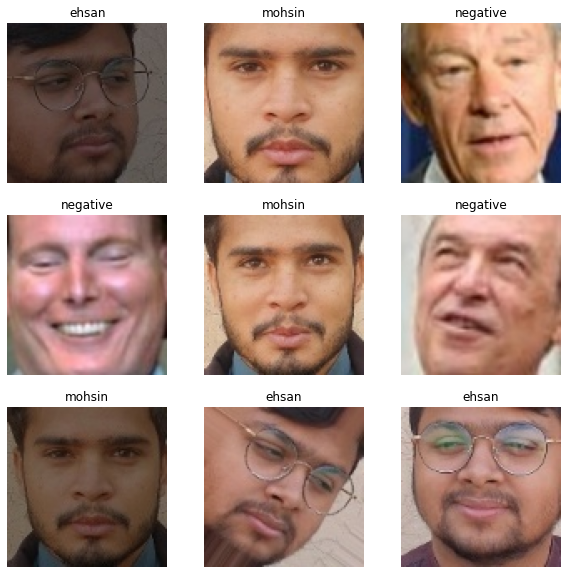

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
data_augmentation = tf.keras.models.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMG_HEIGHT, 
                                                              IMG_WIDTH,
                                                              3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [25]:
model = tf.keras.models.Sequential([
  data_augmentation,
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),

  tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=512, activation="relu"),
  tf.keras.layers.Dropout(rate=0.1),
  tf.keras.layers.Dense(units=512, activation="relu"),
  tf.keras.layers.Dense(units=num_classes)
])

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 96, 96, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 48, 48, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 64)        18496     
                                                      

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("model.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose = 1)

earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                         min_delta=0,
                         patience=3,
                         verbose=1,
                         restore_best_weights=True)

callbacks = [earlystop, checkpoint]

In [29]:
history = model.fit(
  train_ds,
  validation_data = test_ds,
  epochs = EPOCHS,
  callbacks = callbacks,
)

Epoch 1/100
1416/1416 [==============================] - ETA: 0s - loss: 0.2024 - accuracy: 0.9185
Epoch 1: val_loss improved from inf to 0.05405, saving model to model.h5
1416/1416 [==============================] - 80s 39ms/step - loss: 0.2024 - accuracy: 0.9185 - val_loss: 0.0541 - val_accuracy: 0.9809
Epoch 2/100
1415/1416 [============================>.] - ETA: 0s - loss: 0.0321 - accuracy: 0.9899
Epoch 2: val_loss improved from 0.05405 to 0.00609, saving model to model.h5
1416/1416 [==============================] - 50s 35ms/step - loss: 0.0321 - accuracy: 0.9899 - val_loss: 0.0061 - val_accuracy: 0.9984
Epoch 3/100
1415/1416 [============================>.] - ETA: 0s - loss: 0.0345 - accuracy: 0.9895
Epoch 3: val_loss improved from 0.00609 to 0.00603, saving model to model.h5
1416/1416 [==============================] - 50s 35ms/step - loss: 0.0345 - accuracy: 0.9895 - val_loss: 0.0060 - val_accuracy: 0.9988
Epoch 4/100
1416/1416 [==============================] - ETA: 0s - loss

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

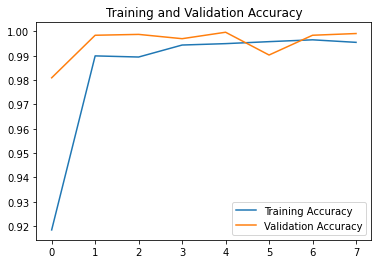

In [31]:
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

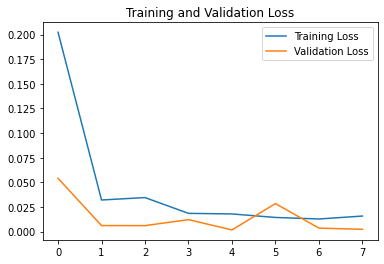

In [32]:
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
loss, accuracy = model.evaluate(val_dataset)

177/177 [==============================] - 5s 27ms/step - loss: 0.0023 - accuracy: 0.9991


In [36]:
# Reload model 
cnn = tf.keras.models.load_model('model.h5', compile=True)

In [37]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(cnn)
tflite_model = converter.convert()
open("model.tflite", "wb").write(tflite_model)

21493768

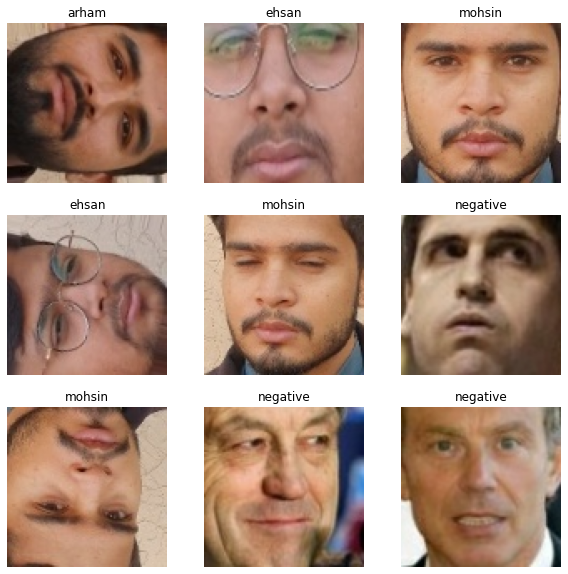

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in val_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    pred = cnn.predict(tf.expand_dims(images[i], 0))
    # plt.title(class_names[labels[i]])
    plt.title(class_names[np.argmax(tf.nn.softmax(pred))])
    plt.axis("off")